# Transient Heat Conduction in Various Geometries

Keywords: ipopt usage, dae, differential-algebraic equations, pde, partial differential equations

## Imports

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D

import shutil
import sys
import os.path

if "google.colab" in sys.modules:
    !wget 'https://raw.githubusercontent.com/IDAES/idaes-pse/main/scripts/colab_helper.py'
    import colab_helper

    colab_helper.install_idaes()
    colab_helper.install_ipopt()

assert shutil.which("ipopt") or os.path.isfile("ipopt")
from pyomo.environ import (
    ConcreteModel,
    Var,
    Constraint,
    Objective,
    TransformationFactory,
    SolverFactory,
)
from pyomo.dae import ContinuousSet, DerivativeVar

# Uncomment the following line if you installed Ipopt via IDAES on your local machine
# but cannot find the Ipopt executable. Our Colab helper script takes care of the
# # environmental variables if you are  on Colab. Otherwise, you need to either import
# idaes or set the path environmental variable yourself.
#
# import idaes

## Rescaling the heat equation

Transport of heat in a solid is described by the familiar thermal diffusion model

$$
\begin{align*}
\rho C_p\frac{\partial T}{\partial t} & = \nabla\cdot(k\nabla T)
\end{align*}
$$

We'll assume the thermal conductivity $k$ is a constant, and define thermal diffusivity in the conventional way

$$
\begin{align*}
\alpha & = \frac{k}{\rho C_p}
\end{align*}
$$

We will further assume symmetry with respect to all spatial coordinates except $r$ where $r$ extends from $-R$ to $+R$. The boundary conditions are

$$
\begin{align*}
T(t,R) & = T_{\infty} & \forall t > 0 \\
\nabla T(t,0) & = 0 & \forall t \geq 0 
\end{align*}
$$

where we have assumed symmetry with respect to $r$ and uniform initial conditions $T(0, r) = T_0$ for all $0 \leq r \leq R$. Following standard scaling procedures, we introduce the dimensionless variables

$$
\begin{align*}
T' & = \frac{T - T_0}{T_\infty - T_0} \\
r' & = \frac{r}{R} \\
t' & = t \frac{\alpha}{R^2}
\end{align*}
$$

## Dimensionless model

Under these conditions the problem reduces to 

$$
\begin{align*}
\frac{\partial T'}{\partial t'} & = \nabla^2 T'
\end{align*}
$$

with auxiliary conditions

$$
\begin{align*}
T'(0, r') & = 0 & \forall 0 \leq r' \leq 1\\
T'(t', 1) & = 1 & \forall t' > 0\\
\nabla T'(t', 0) & = 0 & \forall t' \geq 0 \\
\end{align*}
$$

which we can specialize to specific geometries.

## Preliminary code

In [2]:
def model_plot(m):
    r = sorted(m.r)
    t = sorted(m.t)

    rgrid = np.zeros((len(t), len(r)))
    tgrid = np.zeros((len(t), len(r)))
    Tgrid = np.zeros((len(t), len(r)))

    for i in range(0, len(t)):
        for j in range(0, len(r)):
            rgrid[i, j] = r[j]
            tgrid[i, j] = t[i]
            Tgrid[i, j] = m.T[t[i], r[j]].value

    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(1, 1, 1, projection="3d")
    ax.set_xlabel("Distance r")
    ax.set_ylabel("Time t")
    ax.set_zlabel("Temperature T")
    p = ax.plot_wireframe(rgrid, tgrid, Tgrid)
    plt.show()

## Planar coordinates

Suppressing the prime notation, for a slab geometry the model specializes to 

$$
\begin{align*}
\frac{\partial T}{\partial t} & = \frac{\partial^2 T}{\partial r^2}
\end{align*}
$$

with auxiliary conditions

$$
\begin{align*}
T(0, r) & = 0 & \forall 0 \leq r \leq 1 \\
T(t, 1) & = 1 & \forall t > 0\\
\frac{\partial T}{\partial r} (t, 0) & = 0 & \forall t \geq 0 \\
\end{align*}
$$

In [3]:
m = ConcreteModel()

m.r = ContinuousSet(bounds=(0, 1))
m.t = ContinuousSet(bounds=(0, 2))

m.T = Var(m.t, m.r)

m.dTdt = DerivativeVar(m.T, wrt=m.t)
m.dTdr = DerivativeVar(m.T, wrt=m.r)

# This will not work because Pyomo.DAE does not know to use the boundary condition on the derivative
# m.d2Tdr2 = DerivativeVar(m.T, wrt=(m.r, m.r), bounds=(-100,100))

# This way Pyomo.DAE knows to use the boundary condition on the derivative at r=0
m.d2Tdr2 = DerivativeVar(m.dTdr, wrt=m.r, initialize=0.0)


@m.Constraint(m.t, m.r)
def pde(m, t, r):
    if t == 0:
        return Constraint.Skip
    if r == 0:
        return Constraint.Skip
    return m.dTdt[t, r] == m.d2Tdr2[t, r]


m.obj = Objective(expr=1)

# Initial condition
m.ic = Constraint(m.r, rule=lambda m, r: m.T[0, r] == 0 if r < 1 else Constraint.Skip)

# Boundary conditions on temperature
m.bc1 = Constraint(m.t, rule=lambda m, t: m.T[t, 1] == 1)

# Boundary conditions on temperature gradient
# End is insulated
m.bc2 = Constraint(m.t, rule=lambda m, t: m.dTdr[t, 0] == 0)

# This needs to be backwards in time because:
# 1. The initial condition is at t=0
# 2. The insulated boundary condition is at r=0
TransformationFactory("dae.finite_difference").apply_to(
    m, nfe=50, scheme="BACKWARD", wrt=m.r
)
TransformationFactory("dae.finite_difference").apply_to(
    m, nfe=50, scheme="BACKWARD", wrt=m.t
)

# If we do not use BACKWARDS AND BACKWARDS, we have extra degrees of freedom
import idaes
from idaes.core.util.model_diagnostics import degrees_of_freedom

print("Degrees of Freedom:", degrees_of_freedom(m))

Degrees of Freedom: 0


Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

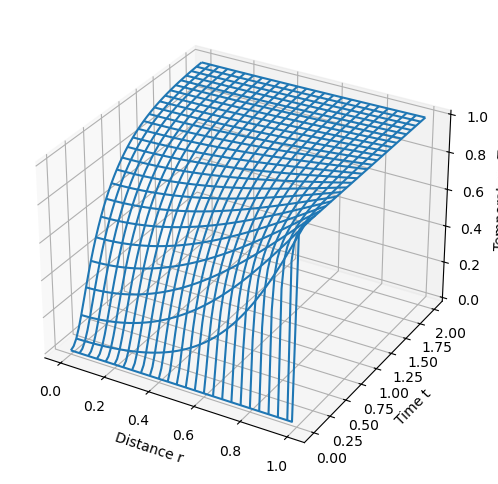

In [4]:
SolverFactory("ipopt").solve(m, tee=True).write()
model_plot(m)

## Cylindrical coordinates

Suppressing the prime notation, for a cylindrical geometry the model specializes to 

$$
\begin{align*}
\frac{\partial T}{\partial t} & = \frac{1}{r}\frac{\partial}{\partial r}\left(r\frac{\partial T}{\partial r}\right)
\end{align*}
$$

Expanding,

$$
\begin{align*}
\frac{\partial T}{\partial t} & = \frac{\partial^2 T}{\partial r^2} + \frac{1}{r}\frac{\partial T}{\partial r}
\end{align*}
$$

with auxiliary conditions

$$
\begin{align*}
T(0, r) & = 0 & \forall 0 \leq r \leq 1\\
T(t, 1) & = 1 & \forall t > 0\\
\frac{\partial T}{\partial r} (t, 0) & = 0 & \forall t \geq 0 \\
\end{align*}
$$

In [5]:
m = ConcreteModel()

m.r = ContinuousSet(bounds=(0, 1))
m.t = ContinuousSet(bounds=(0, 2))

m.T = Var(m.t, m.r)

m.dTdt = DerivativeVar(m.T, wrt=m.t)
m.dTdr = DerivativeVar(m.T, wrt=m.r)

# This will give too many degrees of freedom
# m.d2Tdr2 = DerivativeVar(m.T, wrt=(m.r, m.r))
m.d2Tdr2 = DerivativeVar(m.dTdr, wrt=m.r)


@m.Constraint(m.t, m.r)
def pde(m, t, r):
    if t == 0:
        return Constraint.Skip
    if r == 0:
        return Constraint.Skip
    return m.dTdt[t, r] == m.d2Tdr2[t, r] + (1 / r) * m.dTdr[t, r]


m.ic = Constraint(m.r, rule=lambda m, r: m.T[0, r] == 0)
m.bc1 = Constraint(m.t, rule=lambda m, t: m.T[t, 1] == 1 if t > 0 else Constraint.Skip)
m.bc2 = Constraint(m.t, rule=lambda m, t: m.dTdr[t, 0] == 0)

TransformationFactory("dae.finite_difference").apply_to(
    m, nfe=20, wrt=m.r, scheme="BACKWARD"
)
TransformationFactory("dae.finite_difference").apply_to(
    m, nfe=50, wrt=m.t, scheme="BACKWARD"
)

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

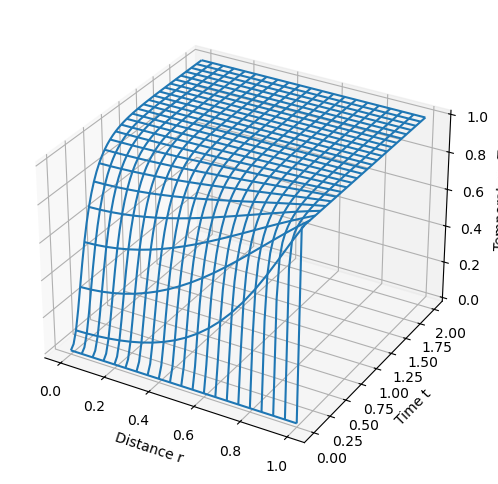

In [6]:
SolverFactory("ipopt").solve(m, tee=True).write()

model_plot(m)

### Central Finite Difference

## Spherical coordinates

Suppressing the prime notation, for a cylindrical geometry the model specializes to 

$$
\begin{align*}
\frac{\partial T}{\partial t} & = \frac{1}{r^2}\frac{\partial}{\partial r}\left(r^2\frac{\partial T}{\partial r}\right)
\end{align*}
$$

Expanding,

$$
\begin{align*}
\frac{\partial T}{\partial t} & = \frac{\partial^2 T}{\partial r^2} + \frac{2}{r}\frac{\partial T}{\partial r}
\end{align*}
$$

with auxiliary conditions

$$
\begin{align*}
T(0, r) & = 0 & \forall 0 \leq r \leq 1\\
T(t, 1) & = 1 & \forall t > 0\\
\frac{\partial T}{\partial r} (t, 0) & = 0 & \forall t \geq 0 \\
\end{align*}
$$

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

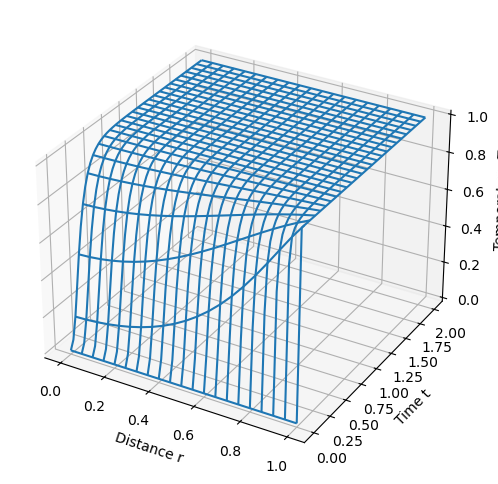

In [7]:
m = ConcreteModel()

m.r = ContinuousSet(bounds=(0, 1))
m.t = ContinuousSet(bounds=(0, 2))

m.T = Var(m.t, m.r)

m.dTdt = DerivativeVar(m.T, wrt=m.t)
m.dTdr = DerivativeVar(m.T, wrt=m.r)

# m.d2Tdr2 = DerivativeVar(m.T, wrt=(m.r, m.r))
m.d2Tdr2 = DerivativeVar(m.dTdr, wrt=m.r)


@m.Constraint(m.t, m.r)
def pde(m, t, r):
    if r == 0 or t == 0:
        return Constraint.Skip
    else:
        return m.dTdt[t, r] == m.d2Tdr2[t, r] + (2 / r) * m.dTdr[t, r]


m.ic = Constraint(m.r, rule=lambda m, r: m.T[0, r] == 0)
m.bc1 = Constraint(m.t, rule=lambda m, t: m.T[t, 1] == 1 if t > 0 else Constraint.Skip)
m.bc2 = Constraint(m.t, rule=lambda m, t: m.dTdr[t, 0] == 0)

TransformationFactory("dae.finite_difference").apply_to(
    m, nfe=20, wrt=m.r, scheme="BACKWARD"
)
TransformationFactory("dae.finite_difference").apply_to(
    m, nfe=50, wrt=m.t, scheme="BACKWARD"
)
SolverFactory("ipopt", tee=True).solve(m, tee=True).write()

model_plot(m)

## Debuging Degrees of Freedom

PDEs are tricky to solve because we need to choose the space and time discretization schemes to match the initial and boundary conditions.

Let's consider a backward formula:

$$
\begin{equation*}
\frac{\partial T}{\partial r} \approx \frac{T_{i} - T_{i-1}}{\Delta r}
\end{equation*}
$$

This means that for the first cell, $i=0$, which occurs at the edge of the object ($r=0$ in our problem), we cannot easily estimate the derivate. Thus, we need a boundary condition and to skip the PDE equation for $r=0$.

We can make a similar argument for the time derivative. We need an initial condition and to skip the PDE equation for $t=0$.

For these heat transfer problems, we need to estimate $\frac{\partial^2 T}{\partial r^2}$ using finite difference. Let's consider a backward formula:

$$
\begin{equation*}
\frac{\partial^2 T}{\partial r^2} \approx \frac{\frac{\partial T}{\partial r}_{i} - \frac{\partial T}{\partial r}_{i-1}}{\Delta r} \approx \frac{T_{i-2} - T_{i-1} - T_{i-1} + T+i}{\Delta r^2}
\end{equation*}
$$

This might suggest that we need to skip the PDE for the first two cells, $i=0$ and $i=1$ in space to estimate the second derivative. But we have a boundary condition for the first derivative at $r=0$, so we are okay if the just skip the first cell in space ($i=0$).

For these reasons, we want to choose backwards finite difference for both space and time in this problem. An early version of this notebook used forward and central, but had extra degrees of freedom.

Finally, below are some codes that are extra helpful for debugging degrees of freedom for PDE discretization.

In [8]:
# Check the degrees of freedom
import idaes
from idaes.core.util.model_diagnostics import degrees_of_freedom

print("Degrees of Freedom:", degrees_of_freedom(m))

Degrees of Freedom: 0


In [9]:
# Use the IDAES diagnostics toolbox to check for structural issues
from idaes.core.util import DiagnosticsToolbox

dt = DiagnosticsToolbox(m)
dt.report_structural_issues()
dt.display_underconstrained_set()
dt.display_overconstrained_set()

Model Statistics

        Activated Blocks: 1 (Deactivated: 0)
        Free Variables in Activated Constraints: 4212 (External: 0)
            Free Variables with only lower bounds: 0
            Free Variables with only upper bounds: 0
            Free Variables with upper and lower bounds: 0
        Fixed Variables in Activated Constraints: 0 (External: 0)
        Activated Equality Constraints: 4212 (Deactivated: 0)
        Activated Inequality Constraints: 0 (Deactivated: 0)
        Activated Objectives: 0 (Deactivated: 0)

------------------------------------------------------------------------------------
0 WARNINGS

    No warnings found!

------------------------------------------------------------------------------------
1 Cautions

    Caution: 72 unused variables (0 fixed)

------------------------------------------------------------------------------------
Suggested next steps:

    Try to initialize/solve your model and then call report_numerical_issues()

Dulmage-Mendelso

Finally, if you are still stuck after using the diagnostics toolbox (and `m.pprint()`), you can add temporary objective to the model to maximize the sum of one of the derivatives. Then plot the PDE solution and look for strange anomalies, which can help you hone in on the misspecification. This gives similar information as the under constrained set, but is graphical.